<a href="https://colab.research.google.com/github/varshikarajesh/ECG-Retrival/blob/main/Minorproj_ECGRetrival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 141.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, json, zipfile, tarfile, requests, numpy as np, pandas as pd
from pathlib import Path
from tqdm import tqdm
import wfdb
from scipy.signal import resample_poly

Data loading, preprocessing and scp


In [4]:
# Startup + preprocessing for PTB-XL with auto-detect of DATA_ROOT
import os, sys, subprocess, zipfile, json, ast
from pathlib import Path
import numpy as np
import pandas as pd

# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

# Paths
ZIP_IN_DRIVE = Path("/content/drive/MyDrive/dataset_ecg/ptb-xl-1.0.3.zip")   # adjust if your zip is elsewhere
EXTRACT_DIR  = Path("/content/drive/MyDrive/dataset_ecg/ptbxl_raw")         # will hold extracted dataset
OUT_ROOT     = Path("/content/drive/MyDrive/dataset_ecg/ptbxl_out")         # preprocessed outputs
SR = 100

OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Extract if needed
if not EXTRACT_DIR.exists():
    print("Extracting PTB-XL zip to", EXTRACT_DIR)
    with zipfile.ZipFile(ZIP_IN_DRIVE, "r") as zf:
        zf.extractall(EXTRACT_DIR)

# Auto-detect DATA_ROOT (folder with ptbxl_database.csv)
DATA_ROOT = None
for root, dirs, files in os.walk(EXTRACT_DIR):
    if "ptbxl_database.csv" in files:
        DATA_ROOT = Path(root)
        break
if DATA_ROOT is None:
    raise FileNotFoundError("Could not find ptbxl_database.csv under " + str(EXTRACT_DIR))
print("Using DATA_ROOT =", DATA_ROOT)

# If already processed, just load CSVs
if (OUT_ROOT / "meta_train.csv").exists() and (OUT_ROOT / "label_map.json").exists():
    print("Found existing preprocessed PTB-XL in", OUT_ROOT)
    train_meta = pd.read_csv(OUT_ROOT / "meta_train.csv")
    val_meta   = pd.read_csv(OUT_ROOT / "meta_val.csv")
    test_meta  = pd.read_csv(OUT_ROOT / "meta_test.csv")
    with open(OUT_ROOT / "label_map.json") as f:
        label_list = json.load(f)
    print("Train:", train_meta.shape, "Val:", val_meta.shape, "Test:", test_meta.shape)
    print("Labels:", len(label_list))
else:
    # Install wfdb if missing
    try:
        import wfdb
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "wfdb"])
        import wfdb
    from scipy.signal import butter, filtfilt

    # Helpers
    def bandpass_filter(x, fs, lo=0.5, hi=40.0, order=4):
        nyq = 0.5 * fs
        b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
        return filtfilt(b, a, x, axis=1)

    def load_wfdb_signal(record_path_no_ext):
        rec = wfdb.rdrecord(record_path_no_ext)
        sig = rec.p_signal.T
        return sig.astype(np.float32), int(rec.fs)

    def resample_if_needed(sig, fs_in, fs_out):
        if fs_in == fs_out:
            return sig
        try:
            from math import gcd
            from scipy.signal import resample_poly
            g = gcd(fs_in, fs_out)
            up, down = fs_out // g, fs_in // g
            return resample_poly(sig, up, down, axis=1).astype(np.float32)
        except Exception:
            from scipy.signal import resample
            T_out = int(round(sig.shape[1] * fs_out / fs_in))
            return resample(sig, T_out, axis=1).astype(np.float32)

    def fix_length(sig, target_len):
        L = sig.shape[1]
        if L == target_len: return sig
        if L > target_len: return sig[:, :target_len]
        pad = np.zeros((sig.shape[0], target_len - L), dtype=sig.dtype)
        return np.concatenate([sig, pad], axis=1)

    def parse_scp_codes(s):
        if isinstance(s, dict): return s
        return ast.literal_eval(s)

    def build_label_map(df):
        keys=set()
        for x in df["scp_codes"]:
            keys.update(parse_scp_codes(x).keys())
        return sorted(list(keys))   # all ~71 labels

    def scp_to_multihot(scp, label_list):
        idx = {k:i for i,k in enumerate(label_list)}
        y = np.zeros(len(label_list), dtype=np.int8)
        for k in scp.keys():
            if k in idx: y[idx[k]] = 1
        return y

    def official_split(df, val_fold=9, test_fold=10):
        train = df[(df["strat_fold"] != val_fold) & (df["strat_fold"] != test_fold)]
        return train, df[df["strat_fold"] == val_fold], df[df["strat_fold"] == test_fold]

    def process_split(meta, label_list, out_dir, sr):
        from tqdm import tqdm
        paths, labels = [], []
        out_dir.mkdir(parents=True, exist_ok=True)
        for _, row in tqdm(meta.iterrows(), total=len(meta), desc=f"Process {out_dir.name}"):
            rid = row["ecg_id"]
            rec_no_ext = row["filename_lr"] if sr == 100 else row["filename_hr"]
            rec_path_no_ext = (DATA_ROOT / rec_no_ext).with_suffix("")
            sig, fs = load_wfdb_signal(str(rec_path_no_ext))
            sig = resample_if_needed(sig, fs, sr)
            sig = bandpass_filter(sig, sr, 0.5, 40.0, 4)
            sig = fix_length(sig, 10 * sr)
            out_path = out_dir / f"{rid}.npy"
            np.save(out_path, sig.astype(np.float32))
            paths.append(str(out_path))
            labels.append(scp_to_multihot(parse_scp_codes(row["scp_codes"]), label_list))
        return paths, labels

    def compute_scaler(paths):
        from tqdm import tqdm
        mean = M2 = None; count = 0
        for p in tqdm(paths, desc="Compute scaler"):
            x = np.load(p)
            if mean is None:
                leads = x.shape[0]
                mean = np.zeros(leads, dtype=np.float64)
                M2   = np.zeros(leads, dtype=np.float64)
            count += x.shape[1]
            mean  += x.sum(axis=1)
            M2    += (x**2).sum(axis=1)
        mean = mean / count
        var  = M2 / count - mean**2
        std  = np.sqrt(np.maximum(var, 1e-8))
        return mean.astype(np.float32), std.astype(np.float32)

    def apply_scaler(paths, mean, std):
        from tqdm import tqdm
        for p in tqdm(paths, desc="Apply scaler"):
            x = np.load(p)
            x = (x - mean[:, None]) / std[:, None]
            np.save(p, x.astype(np.float32))

    def save_manifest(csv_path, paths, labels, ids, patients):
        pd.DataFrame({
            "record_path": paths,
            "label_vec": [json.dumps(l.tolist()) for l in labels],
            "ecg_id": ids,
            "patient_id": patients,
        }).to_csv(csv_path, index=False)

    # Run preprocessing
    meta_csv = DATA_ROOT / "ptbxl_database.csv"
    meta = pd.read_csv(meta_csv)
    label_list = build_label_map(meta)
    with open(OUT_ROOT / "label_map.json", "w") as f:
        json.dump(label_list, f, indent=2)

    train_meta, val_meta, test_meta = official_split(meta, val_fold=9, test_fold=10)

    p_tr, y_tr = process_split(train_meta, label_list, OUT_ROOT / f"{SR}hz_scaled" / "train", SR)
    p_va, y_va = process_split(val_meta,   label_list, OUT_ROOT / f"{SR}hz_scaled" / "val", SR)
    p_te, y_te = process_split(test_meta,  label_list, OUT_ROOT / f"{SR}hz_scaled" / "test", SR)

    mean, std = compute_scaler(p_tr)
    np.savez(OUT_ROOT / f"scaler_stats_{SR}hz.npz", mean=mean, std=std)
    apply_scaler(p_tr, mean, std); apply_scaler(p_va, mean, std); apply_scaler(p_te, mean, std)

    save_manifest(OUT_ROOT / "meta_train.csv", p_tr, y_tr, train_meta["ecg_id"].tolist(), train_meta["patient_id"].tolist())
    save_manifest(OUT_ROOT / "meta_val.csv",   p_va, y_va, val_meta["ecg_id"].tolist(),   val_meta["patient_id"].tolist())
    save_manifest(OUT_ROOT / "meta_test.csv",  p_te, y_te, test_meta["ecg_id"].tolist(),  test_meta["patient_id"].tolist())

    print("Preprocessing complete. Saved under:", OUT_ROOT)

    # Load manifests
    train_meta = pd.read_csv(OUT_ROOT / "meta_train.csv")
    val_meta   = pd.read_csv(OUT_ROOT / "meta_val.csv")
    test_meta  = pd.read_csv(OUT_ROOT / "meta_test.csv")
    with open(OUT_ROOT / "label_map.json") as f:
        label_list = json.load(f)
    print("Train:", train_meta.shape, "Val:", val_meta.shape, "Test:", test_meta.shape)
    print("Labels:", len(label_list))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using DATA_ROOT = /content/drive/MyDrive/dataset_ecg/ptbxl_raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3
Found existing preprocessed PTB-XL in /content/drive/MyDrive/dataset_ecg/ptbxl_out
Train: (17418, 4) Val: (2183, 4) Test: (2198, 4)
Labels: 71


Data augmentation

In [5]:
# Data augmentation functions for PTB-XL ECG signals
import numpy as np
import random

# Add Gaussian noise
def add_gaussian_noise(sig: np.ndarray, noise_level: float = 0.01) -> np.ndarray:
    noise = np.random.normal(0, noise_level, sig.shape)
    return sig + noise.astype(sig.dtype)

# Random scaling (per-lead gain variation)
def random_scaling(sig: np.ndarray, scale_range=(0.9, 1.1)) -> np.ndarray:
    scales = np.random.uniform(scale_range[0], scale_range[1], (sig.shape[0], 1))
    return sig * scales.astype(sig.dtype)

# Random shift (circular or padded shift along time axis)
def random_shift(sig: np.ndarray, max_shift: int = 20) -> np.ndarray:
    T = sig.shape[1]
    shift = np.random.randint(-max_shift, max_shift + 1)
    if shift == 0:
        return sig
    elif shift > 0:
        return np.pad(sig, ((0,0),(shift,0)), mode="constant")[:, :T]
    else:
        return np.pad(sig, ((0,0),(0,-shift)), mode="constant")[:, -shift:]

# Random time masking (zero out a short interval)
def random_time_mask(sig: np.ndarray, max_mask: int = 50) -> np.ndarray:
    T = sig.shape[1]
    mask_len = np.random.randint(1, max_mask + 1)
    start = np.random.randint(0, T - mask_len)
    sig_copy = sig.copy()
    sig_copy[:, start:start+mask_len] = 0
    return sig_copy

# Lead dropout (simulate missing leads)
def dropout_leads(sig: np.ndarray, drop_prob: float = 0.2) -> np.ndarray:
    sig_copy = sig.copy()
    for lead in range(sig.shape[0]):
        if random.random() < drop_prob:
            sig_copy[lead, :] = 0
    return sig_copy

# Combine augmentations
def augment_ecg(sig: np.ndarray) -> np.ndarray:
    """Apply a random combination of augmentations."""
    if random.random() < 0.5:
        sig = add_gaussian_noise(sig, noise_level=0.01)
    if random.random() < 0.5:
        sig = random_scaling(sig)
    if random.random() < 0.5:
        sig = random_shift(sig, max_shift=20)
    if random.random() < 0.3:
        sig = random_time_mask(sig, max_mask=50)
    if random.random() < 0.2:
        sig = dropout_leads(sig, drop_prob=0.2)
    return sig.astype(np.float32)

# Test on one file
import json, ast

train_meta = pd.read_csv(OUT_ROOT / "meta_train.csv")
example_path = train_meta.iloc[0]["record_path"]
x = np.load(example_path)  # shape (12,1000)
print("Original shape:", x.shape)

aug = augment_ecg(x)
print("Augmented shape:", aug.shape)

Original shape: (12, 1000)
Augmented shape: (12, 1000)


Windowing

In [6]:
def sliding_window_ecg(ecg, window_sec=10, stride_sec=5, fs=500):
    """
    ecg: (C, T)
    returns: list of windows (C, window_samples)
    """
    window_samples = window_sec * fs
    stride_samples = stride_sec * fs

    windows = []
    T = ecg.shape[1]

    for start in range(0, T - window_samples + 1, stride_samples):
        window = ecg[:, start:start + window_samples]
        windows.append(window)

    return windows


In [7]:
import os
DATA_DIR = "/content/drive/MyDrive/dataset_ecg/ptbxl_out/100hz_scaled"
print(" Files in directory:\n")
for f in sorted(os.listdir(DATA_DIR)):
    print(f)

 Files in directory:

test
train
val


In [8]:
# =====================================================
# SINGLE-CELL PTB-XL LOADER (ECG FILES + META LABELS)
# =====================================================

import os
import numpy as np

BASE_DIR = "/content/drive/MyDrive/dataset_ecg/ptbxl_out/100hz_scaled"
fs = 100  # using 100hz_scaled

def load_split(split, meta_df, label_col):
    """
    split     : 'train' | 'val' | 'test'
    meta_df   : meta_train / meta_val / meta_test DataFrame
    label_col : column name containing labels
    """

    split_dir = os.path.join(BASE_DIR, split)

    # sort ECG files numerically: 0.npy ... N.npy
    files = sorted(
        [f for f in os.listdir(split_dir) if f.endswith(".npy")],
        key=lambda x: int(os.path.splitext(x)[0])
    )

    # load ECG signals
    X = [np.load(os.path.join(split_dir, f)) for f in files]
    X = np.stack(X)

    # ensure (N,12,T)
    if X.shape[1] != 12:
        X = np.transpose(X, (0, 2, 1))

    # extract labels from metadata
    y = meta_df[label_col].values[:len(X)]

    print(f"{split.upper():5s} | ECG: {X.shape} | Labels: {y.shape}")
    return X, y


In [9]:
import os
import numpy as np

BASE_DIR = "/content/drive/MyDrive/dataset_ecg/ptbxl_out/100hz_scaled"
fs = 100  # sampling rate

def load_split_safe(split, meta_df):
    split_dir = os.path.join(BASE_DIR, split)

    files = sorted(
        [f for f in os.listdir(split_dir) if f.endswith(".npy")],
        key=lambda x: int(os.path.splitext(x)[0])
    )

    X = []
    y = []
    bad_files = 0

    for i, f in enumerate(files):
        try:
            ecg = np.load(os.path.join(split_dir, f))
            X.append(ecg)
            y.append(meta_df["label_vec"].iloc[i])
        except Exception as e:
            bad_files += 1
            continue  # skip corrupted file

    X = np.stack(X)

    # Ensure (N,12,T)
    if X.shape[1] != 12:
        X = np.transpose(X, (0, 2, 1))

    y = np.stack(y)

    print(f"{split.upper():5s} | ECG: {X.shape} | Labels: {y.shape} | Skipped: {bad_files}")
    return X, y


# -------- LOAD ALL SPLITS SAFELY --------
X_train, y_train = load_split_safe("train", train_meta)
X_val,   y_val   = load_split_safe("val",   val_meta)
X_test,  y_test  = load_split_safe("test",  test_meta)

print("\n ALL SPLITS LOADED (CORRUPTED FILES SKIPPED)")


TRAIN | ECG: (17418, 12, 1000) | Labels: (17418,) | Skipped: 0
VAL   | ECG: (2182, 12, 1000) | Labels: (2182,) | Skipped: 1
TEST  | ECG: (2198, 12, 1000) | Labels: (2198,) | Skipped: 0

 ALL SPLITS LOADED (CORRUPTED FILES SKIPPED)


In [10]:
def window_dataset(X, y):
    Xw, yw = [], []

    for ecg, label_vec in zip(X, y):
        windows = sliding_window_ecg(ecg)  # ← your existing function

        for w in windows:
            Xw.append(w)
            yw.append(label_vec)  # same label for all windows

    return np.array(Xw), np.array(yw)


In [11]:
X_train_w, y_train_w = window_dataset(X_train, y_train)
X_val_w,   y_val_w   = window_dataset(X_val, y_val)

print("Train windows:", X_train_w.shape)
print("Val windows  :", X_val_w.shape)


Train windows: (0,)
Val windows  : (0,)


In [12]:
# =====================================
# FIX WINDOWING CONFIG (CRITICAL)
# =====================================

# Override fs to match 100hz_scaled data
FS = 100

# Re-run windowing with correct sampling rate
def window_dataset(X, y):
    Xw, yw = [], []

    for ecg, label_vec in zip(X, y):
        windows = sliding_window_ecg(
            ecg,
            window_sec=10,
            stride_sec=5,
            fs=FS         )

        for w in windows:
            Xw.append(w)
            yw.append(label_vec)

    return np.array(Xw), np.array(yw)


X_train_w, y_train_w = window_dataset(X_train, y_train)
X_val_w,   y_val_w   = window_dataset(X_val, y_val)

print("Train windows:", X_train_w.shape)
print("Val windows  :", X_val_w.shape)


Train windows: (17418, 12, 1000)
Val windows  : (2182, 12, 1000)


In [13]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import ast

def parse_label_vec(y):
    """
    Converts string-based label vectors to numeric numpy arrays.
    Handles formats like:
    "[0,1,0,...]" or "0 1 0 ..."
    """
    parsed = []

    for v in y:
        if isinstance(v, str):
            try:
                # Case 1: "[0, 1, 0, ...]"
                vec = np.array(ast.literal_eval(v), dtype=np.float32)
            except:
                # Case 2: "0 1 0 ..."
                vec = np.array(list(map(float, v.split())), dtype=np.float32)
            parsed.append(vec)
        else:
            parsed.append(np.asarray(v, dtype=np.float32))

    return np.stack(parsed)


# ---- FIX LABELS ----
y_train_w = parse_label_vec(y_train_w)
y_val_w   = parse_label_vec(y_val_w)

print(" Labels converted:")
print("Train labels:", y_train_w.shape, y_train_w.dtype)
print("Val labels  :", y_val_w.shape, y_val_w.dtype)


# ---- DATASET (SAFE) ----
class ECGWindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ---- CREATE LOADERS ----
train_ds = ECGWindowDataset(X_train_w, y_train_w)
val_ds   = ECGWindowDataset(X_val_w, y_val_w)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

# ---- SANITY CHECK ----
xb, yb = next(iter(train_loader))
print(" Batch ECG:", xb.shape)
print(" Batch labels:", yb.shape)


 Labels converted:
Train labels: (17418, 71) float32
Val labels  : (2182, 71) float32
 Batch ECG: torch.Size([32, 12, 1000])
 Batch labels: torch.Size([32, 71])


Embedding Network (ECG → Vector)

In [14]:
import torch.nn as nn
import torch.nn.functional as F


In [15]:
class ECGEmbeddingNet(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(12, 32, 7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, 5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, 5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(128, emb_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x).squeeze(-1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)


Multi-Label Similarity

In [16]:
def label_similarity(y1, y2):
    intersection = (y1 * y2).sum()
    union = ((y1 + y2) > 0).sum()
    return intersection / (union + 1e-8)


Triplet Sampling (Multi-Label Aware)


In [17]:
import random


In [18]:
def sample_triplet(batch_x, batch_y, pos_thresh=0.3, neg_thresh=0.05):
    """
    Anchor-positive: share enough labels
    Anchor-negative: share almost no labels
    """

    N = len(batch_x)
    anchor_idx = random.randint(0, N - 1)

    anchor_x = batch_x[anchor_idx]
    anchor_y = batch_y[anchor_idx]

    positives, negatives = [], []

    for i in range(N):
        sim = label_similarity(anchor_y, batch_y[i])
        if sim >= pos_thresh:
            positives.append(i)
        elif sim <= neg_thresh:
            negatives.append(i)

    if not positives or not negatives:
        return None

    pos_idx = random.choice(positives)
    neg_idx = random.choice(negatives)

    return anchor_x, batch_x[pos_idx], batch_x[neg_idx]


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ECGEmbeddingNet(emb_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.TripletMarginLoss(margin=1.0)


In [20]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    valid_steps = 0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        triplet = sample_triplet(Xb, yb)
        if triplet is None:
            continue

        a, p, n = triplet

        za = model(a.unsqueeze(0))
        zp = model(p.unsqueeze(0))
        zn = model(n.unsqueeze(0))

        loss = criterion(za, zp, zn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        valid_steps += 1

    return total_loss / max(valid_steps, 1)


In [21]:
for epoch in range(10):
    loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1}: Triplet Loss = {loss:.4f}")


Epoch 1: Triplet Loss = 0.7193
Epoch 2: Triplet Loss = 0.5710
Epoch 3: Triplet Loss = 0.6262
Epoch 4: Triplet Loss = 0.6413
Epoch 5: Triplet Loss = 0.5847
Epoch 6: Triplet Loss = 0.5832
Epoch 7: Triplet Loss = 0.5096
Epoch 8: Triplet Loss = 0.5456
Epoch 9: Triplet Loss = 0.5328
Epoch 10: Triplet Loss = 0.5021


Validate (recall)

In [22]:
import torch

def compute_embeddings(model, loader):
    model.eval()
    embs = []
    labels = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            z = model(xb)
            embs.append(z.cpu())
            labels.append(yb)

    return torch.cat(embs), torch.cat(labels)


In [23]:
train_embs, train_lbls = compute_embeddings(model, train_loader)
val_embs,   val_lbls   = compute_embeddings(model, val_loader)


In [24]:
import torch.nn.functional as F

def recall_at_k(query_embs, query_lbls, db_embs, db_lbls, k=5):
    hits = 0

    for i in range(len(query_embs)):
        dists = F.pairwise_distance(
            query_embs[i].unsqueeze(0), db_embs
        )

        nn_idx = torch.topk(dists, k, largest=False).indices

        # check label overlap
        for j in nn_idx:
            if (query_lbls[i] * db_lbls[j]).sum() > 0:
                hits += 1
                break

    return hits / len(query_embs)


In [25]:
for k in [1, 5, 10]:
    r = recall_at_k(val_embs, val_lbls, train_embs, train_lbls, k)
    print(f"Recall@{k}: {r:.3f}")


Recall@1: 0.822
Recall@5: 0.956
Recall@10: 0.975


DB

In [26]:
# =====================================================
# CELL 1: BUILD ECG EMBEDDING DATABASE
# =====================================================

import torch

model.eval()

def build_embeddings(model, loader):
    embs = []
    lbls = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            z = model(xb)            # (batch, emb_dim)
            embs.append(z.cpu())
            lbls.append(yb)

    embs = torch.cat(embs)
    lbls = torch.cat(lbls)

    print("Embeddings:", embs.shape)
    print("Labels:", lbls.shape)

    return embs, lbls


train_embs, train_lbls = build_embeddings(model, train_loader)


Embeddings: torch.Size([17418, 128])
Labels: torch.Size([17418, 71])


CREATE FAISS INDEX

In [27]:
# =====================================================
# CELL 2: CREATE FAISS INDEX
# =====================================================
!pip install faiss-cpu
import faiss
import numpy as np

db_vectors = train_embs.numpy().astype("float32")
dim = db_vectors.shape[1]

index = faiss.IndexFlatL2(dim)   # exact L2 search
index.add(db_vectors)

print("FAISS index size:", index.ntotal)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 109.7 MB/s eta 0:00:00
FAISS index size: 17418


CELL 3: ECG → EMBEDDING FUNCTION

In [28]:
# =====================================================
# CELL 3: ECG → EMBEDDING FUNCTION
# =====================================================

def embed_ecg(ecg):
    """
    ecg: (12, 1000)
    returns: (128,)
    """
    windows = sliding_window_ecg(
        ecg,
        window_sec=10,
        stride_sec=5,
        fs=100      # matches 100hz_scaled
    )

    windows = torch.from_numpy(
        np.array(windows, dtype=np.float32)
    ).to(device)

    with torch.no_grad():
        z = model(windows)

    return z[0].cpu().numpy()   # single window ECG


FAISS RETRIEVAL ALGORITHM

In [29]:
# =====================================================
# CELL 4: FAISS RETRIEVAL
# =====================================================

def retrieve_ecg(query_ecg, top_k=5):
    query_vec = embed_ecg(query_ecg).reshape(1, -1).astype("float32")

    D, I = index.search(query_vec, top_k)

    return I[0], D[0]


DECODE DIAGNOSIS LABELS

In [30]:
# =====================================================
# CELL 5: DECODE DIAGNOSIS LABELS
# =====================================================

def decode_label_vec(label_vec):
    return [f"Diagnosis_{i}" for i, v in enumerate(label_vec) if v > 0]


In [31]:
# =====================================================
# ONE CELL: BUILD NaN-SAFE EMBEDDINGS + LABELS
# =====================================================

import numpy as np
import torch
import ast

model.eval()

def parse_label(v):
    if isinstance(v, str):
        try:
            return np.array(ast.literal_eval(v), dtype=np.float32)
        except:
            return np.array(list(map(float, v.split())), dtype=np.float32)
    return np.asarray(v, dtype=np.float32)

clean_embeddings = []
clean_labels = []
bad_count = 0

with torch.no_grad():
    for i, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device)

        # ---- remove NaNs from ECG ----
        xb = torch.nan_to_num(xb, nan=0.0)

        z = model(xb).cpu().numpy()

        for j in range(len(z)):
            emb = z[j]
            lbl = parse_label(yb[j].numpy())

            # ---- checks ----
            if np.isnan(emb).any():
                bad_count += 1
                continue

            if np.isnan(lbl).any():
                bad_count += 1
                continue

            if lbl.sum() == 0:   # optional: skip unlabeled ECGs
                bad_count += 1
                continue

            clean_embeddings.append(emb)
            clean_labels.append(lbl)

clean_embeddings = np.array(clean_embeddings, dtype=np.float32)
clean_labels = np.array(clean_labels, dtype=np.float32)

print(" Clean embeddings:", clean_embeddings.shape)
print(" Clean labels:", clean_labels.shape)
print("Removed samples:", bad_count)


 Clean embeddings: (17418, 128)
 Clean labels: (17418, 71)
Removed samples: 0


In [32]:
# =====================================================
# FINAL DEFINITIVE FIX USING ptbxl_database.csv
# =====================================================

import pandas as pd
import numpy as np
import ast

# ---- Load PTB-XL database (authoritative source) ----
DB_PATH = "/content/drive/MyDrive/dataset_ecg/ptbxl_database.csv"   # uploaded file
db_df = pd.read_csv(DB_PATH)

print("ptbxl_database.csv loaded")
print("Columns:", list(db_df.columns))

# ---- Parse scp_codes column (dict per ECG) ----
def parse_scp_codes(s):
    if isinstance(s, str):
        return list(ast.literal_eval(s).keys())
    return []

all_codes = set()

for s in db_df["scp_codes"]:
    all_codes.update(parse_scp_codes(s))

# IMPORTANT: sort codes to get deterministic order
scp_code_list = sorted(list(all_codes))

print("Total unique SCP codes used:", len(scp_code_list))

# ---- Load SCP statements dictionary ----
SCP_STATEMENTS_PATH = "/content/drive/MyDrive/dataset_ecg/scp_statements.csv"
scp_df = pd.read_csv(SCP_STATEMENTS_PATH)

# Auto-detect SCP code column
for col in ["scp_code", "scp", "code", "statement"]:
    if col in scp_df.columns:
        SCP_CODE_COL = col
        break
else:
    SCP_CODE_COL = scp_df.columns[0]

scp_df[SCP_CODE_COL] = scp_df[SCP_CODE_COL].astype(str)
scp_df = scp_df.set_index(SCP_CODE_COL)

# ---- Build FINAL label index → diagnosis name mapping ----
LABEL_NAMES = []

for code in scp_code_list:
    if code in scp_df.index:
        # Prefer human-readable statement if available
        name = scp_df.loc[code].get("statement", code)
        if pd.isna(name) or str(name).lower() == "nan":
            name = code
    else:
        name = code

    LABEL_NAMES.append(str(name))

LABEL_NAMES = list(LABEL_NAMES)

print("\n LABEL_NAMES built correctly from ptbxl_database.csv")
print("Example labels:", LABEL_NAMES[:10])

# ---- SAFE DECODER ----
def decode_label_vec(label_vec):
    return [
        LABEL_NAMES[i]
        for i, v in enumerate(label_vec)
        if v > 0
    ]


ptbxl_database.csv loaded
Columns: ['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr']
Total unique SCP codes used: 71

 LABEL_NAMES built correctly from ptbxl_database.csv
Example labels: ['1AVB', '2AVB', '3AVB', 'ABQRS', 'AFIB', 'AFLT', 'ALMI', 'AMI', 'ANEUR', 'ASMI']


BASIC TEST(RETRIVAL)

In [33]:
# =====================================================
# FINAL TEST: ECG → EMBEDDING → FAISS → REAL DIAGNOSES
# =====================================================

import numpy as np
import torch
import ast

TOP_K = 5
FS = 100

model.eval()

# ---- helpers ----
def parse_label(v):
    if isinstance(v, str):
        return np.array(ast.literal_eval(v), dtype=np.float32)
    return np.asarray(v, dtype=np.float32)

def decode_label_vec(label_vec):
    return [LABEL_NAMES[i] for i, v in enumerate(label_vec) if v > 0]

# ---- SANITY CHECK: LABEL_NAMES ----
assert len(LABEL_NAMES) == clean_labels.shape[1], \
    "LABEL_NAMES and label_vec dimension mismatch"

print("Label mapping sanity check passed")

# ---- STEP 1: FIND A DISEASED ECG (NOT NORMAL-ONLY) ----
test_idx = None
for i in range(len(X_test)):
    lbl = parse_label(y_test[i])
    decoded = decode_label_vec(lbl)

    if len(decoded) > 0 and not (len(decoded) == 1 and decoded[0] == "NORM"):
        test_idx = i
        break

if test_idx is None:
    raise ValueError(" No diseased ECG found")

# ---- QUERY ECG ----
query_ecg   = X_test[test_idx]
query_label = parse_label(y_test[test_idx])

print("\n QUERY ECG FOUND")
print("Test index:", test_idx)
print("Query diagnoses:", decode_label_vec(query_label))
print("-" * 60)

# ---- ECG → EMBEDDING ----
windows = sliding_window_ecg(
    query_ecg,
    window_sec=10,
    stride_sec=5,
    fs=FS
)

windows = torch.from_numpy(
    np.array(windows, dtype=np.float32)
).to(device)

with torch.no_grad():
    q_emb = model(windows)[0].cpu().numpy()

assert not np.isnan(q_emb).any(), " NaN in query embedding"

# ---- FAISS SEARCH ----
D, I = index.search(
    q_emb.reshape(1, -1).astype("float32"),
    TOP_K
)

# ---- DISPLAY RESULTS ----
print(" FAISS Retrieval Results:\n")

for rank, idx in enumerate(I[0], 1):
    lbl = clean_labels[idx]
    retrieved = decode_label_vec(lbl)
    overlap = decode_label_vec(query_label * lbl)

    print(f"Rank {rank} | Distance: {D[0][rank-1]:.4f}")
    print("Retrieved diagnoses:", retrieved)
    print("Overlap with query :", overlap if overlap else "None")
    print("-" * 60)


Label mapping sanity check passed

 QUERY ECG FOUND
Test index: 0
Query diagnoses: ['NORM', 'SR']
------------------------------------------------------------
 FAISS Retrieval Results:

Rank 1 | Distance: 0.0019
Retrieved diagnoses: ['ABQRS', 'IVCD', 'SR']
Overlap with query : ['SR']
------------------------------------------------------------
Rank 2 | Distance: 0.0024
Retrieved diagnoses: ['NORM', 'STACH']
Overlap with query : ['NORM']
------------------------------------------------------------
Rank 3 | Distance: 0.0025
Retrieved diagnoses: ['1AVB', 'LAFB', 'SBRAD']
Overlap with query : None
------------------------------------------------------------
Rank 4 | Distance: 0.0028
Retrieved diagnoses: ['NORM', 'SR']
Overlap with query : ['NORM', 'SR']
------------------------------------------------------------
Rank 5 | Distance: 0.0029
Retrieved diagnoses: ['INJAS', 'ISCAL', 'LVH']
Overlap with query : None
------------------------------------------------------------


CLINICAL RETRIVAL EST W ECG-TO-ECG TEST

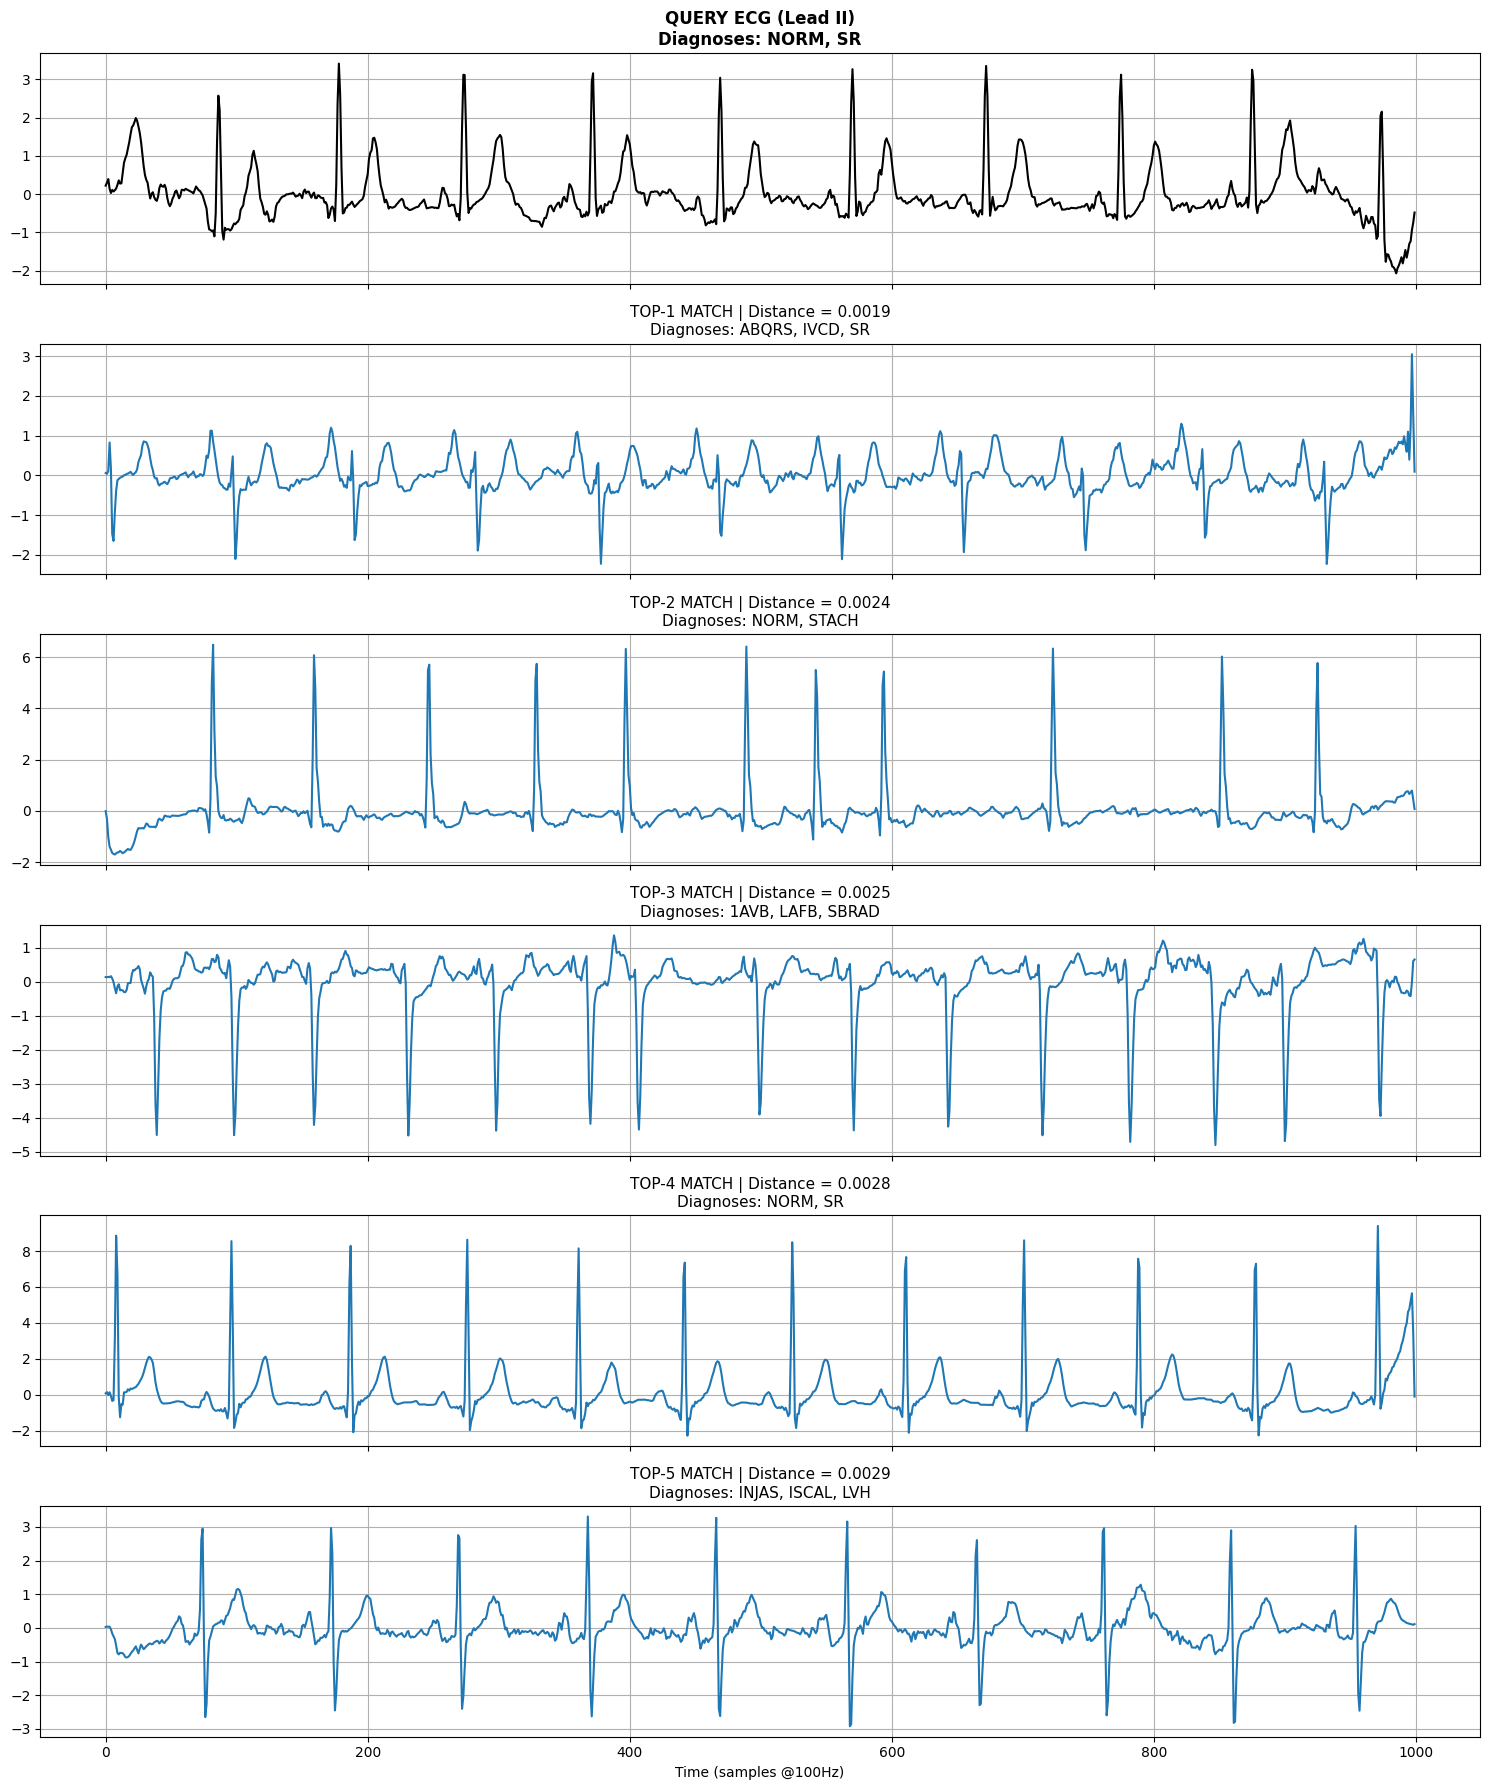

✅ Clinical ECG visualization completed


In [34]:
# =====================================================
# CLINICAL VISUALIZATION: QUERY + TOP-5 ECG RETRIEVAL
# =====================================================

import matplotlib.pyplot as plt
import numpy as np
import torch

FS = 100
TOP_K = 5
LEAD_NAMES = [
    "I","II","III","aVR","aVL","aVF",
    "V1","V2","V3","V4","V5","V6"
]

model.eval()

# ---- helper ----
def decode_label_vec(label_vec):
    return [LABEL_NAMES[i] for i, v in enumerate(label_vec) if v > 0]

# ---- STEP 1: QUERY ECG ----
query_ecg   = X_test[test_idx]        # from previous cell
query_label = parse_label(y_test[test_idx])

query_labels = decode_label_vec(query_label)

# ---- ECG → embedding ----
windows = sliding_window_ecg(
    query_ecg,
    window_sec=10,
    stride_sec=5,
    fs=FS
)

windows = torch.from_numpy(
    np.array(windows, dtype=np.float32)
).to(device)

with torch.no_grad():
    q_emb = model(windows)[0].cpu().numpy()

# ---- FAISS SEARCH ----
D, I = index.search(
    q_emb.reshape(1, -1).astype("float32"),
    TOP_K
)

# =====================================================
# VISUALIZATION
# =====================================================

fig, axes = plt.subplots(
    TOP_K + 1, 1,
    figsize=(15, 3 * (TOP_K + 1)),
    sharex=True
)

# ---- Plot QUERY ECG ----
axes[0].plot(query_ecg[1], color="black")
axes[0].set_title(
    f"QUERY ECG (Lead II)\nDiagnoses: {', '.join(query_labels)}",
    fontsize=12,
    weight="bold"
)
axes[0].grid(True)

# ---- Plot TOP-K RETRIEVED ECGs ----
for rank, idx in enumerate(I[0], 1):
    retrieved_ecg = clean_embeddings[idx]   # embedding only
    train_ecg     = X_train_w[idx][1]       # Lead II
    train_label   = clean_labels[idx]

    diagnoses = decode_label_vec(train_label)

    axes[rank].plot(train_ecg)
    axes[rank].set_title(
        f"TOP-{rank} MATCH | Distance = {D[0][rank-1]:.4f}\n"
        f"Diagnoses: {', '.join(diagnoses)}",
        fontsize=11
    )
    axes[rank].grid(True)

axes[-1].set_xlabel("Time (samples @100Hz)")

plt.tight_layout()
plt.show()

print("✅ Clinical ECG visualization completed")


TEST SAMPLE(LABEL UNMASKED);RETIVAL TEST KAGGLE

In [36]:
# =====================================================
# ONE CELL: TEST UPLOADED KAGGLE ECG (CSV WITH HEADERS)
# =====================================================

import zipfile
import os
import numpy as np
import pandas as pd
import torch

FS_MODEL = 100
WINDOW_SEC = 10
TOP_K = 5

model.eval()

# ---- PATH OF UPLOADED FILE ----
ZIP_PATH = "/content/s0010_re.csv.zip"
EXTRACT_DIR = "/mnt/data/kaggle_ecg_sample"

os.makedirs(EXTRACT_DIR, exist_ok=True)

# ---- EXTRACT ZIP ----
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# ---- LOCATE CSV ----
csv_files = [f for f in os.listdir(EXTRACT_DIR) if f.endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("❌ No CSV file found inside ZIP")

CSV_PATH = os.path.join(EXTRACT_DIR, csv_files[0])
print("Using uploaded ECG file:", CSV_PATH)

# =====================================================
# LOAD CSV SAFELY (HEADERS PRESENT)
# =====================================================

df = pd.read_csv(CSV_PATH)

print("CSV columns:", list(df.columns))
print("CSV shape (rows, cols):", df.shape)

# ---- Keep only numeric columns (drop text/time columns) ----
df = df.select_dtypes(include=[np.number])

if df.shape[1] < 12:
    raise ValueError("❌ Less than 12 numeric ECG leads found")

# ---- Take first 12 leads ----
ecg = df.iloc[:, :12].values.T   # (12, T)

print("Processed ECG shape:", ecg.shape)

# ---- Trim / pad to 10 seconds @100Hz ----
target_len = FS_MODEL * WINDOW_SEC

if ecg.shape[1] >= target_len:
    ecg = ecg[:, :target_len]
else:
    pad_len = target_len - ecg.shape[1]
    ecg = np.pad(ecg, ((0,0),(0,pad_len)), mode="constant")

# ---- NaN SAFETY ----
ecg = np.nan_to_num(ecg, nan=0.0)

# =====================================================
# ECG → EMBEDDING
# =====================================================

windows = sliding_window_ecg(
    ecg,
    window_sec=WINDOW_SEC,
    stride_sec=5,
    fs=FS_MODEL
)

windows = torch.from_numpy(
    np.array(windows, dtype=np.float32)
).to(device)

with torch.no_grad():
    query_emb = model(windows)[0].cpu().numpy()

# =====================================================
# FAISS SEARCH
# =====================================================

D, I = index.search(
    query_emb.reshape(1, -1).astype("float32"),
    TOP_K
)

# ---- Decode diagnoses ----
def decode_label_vec(label_vec):
    return [LABEL_NAMES[i] for i, v in enumerate(label_vec) if v > 0]

print("\n🔍 FAISS Retrieval Results for Uploaded Kaggle ECG:\n")

for rank, idx in enumerate(I[0], 1):
    diagnoses = decode_label_vec(clean_labels[idx])
    print(f"Rank {rank} | Distance: {D[0][rank-1]:.4f}")
    print("Diagnoses:", diagnoses)
    print("-" * 50)

print("✅ Uploaded Kaggle ECG tested successfully")


Using uploaded ECG file: /mnt/data/kaggle_ecg_sample/s0010_re.csv
CSV columns: ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'vx', 'vy', 'vz']
CSV shape (rows, cols): (38400, 15)
Processed ECG shape: (12, 38400)

🔍 FAISS Retrieval Results for Uploaded Kaggle ECG:

Rank 1 | Distance: 0.0213
Diagnoses: ['IMI', 'QWAVE', 'SBRAD']
--------------------------------------------------
Rank 2 | Distance: 0.0236
Diagnoses: ['NORM', 'SR']
--------------------------------------------------
Rank 3 | Distance: 0.0246
Diagnoses: ['ABQRS', 'ASMI', 'IRBBB', 'LMI', 'SR']
--------------------------------------------------
Rank 4 | Distance: 0.0252
Diagnoses: ['NORM', 'SR']
--------------------------------------------------
Rank 5 | Distance: 0.0257
Diagnoses: ['LAFB', 'SR']
--------------------------------------------------
✅ Uploaded Kaggle ECG tested successfully


Data set label assignment test

Kaggle label assignment test

In [37]:
# =====================================================
# ONE CELL: LABEL + JUSTIFICATION FOR KAGGLE ECG SAMPLE
# =====================================================

import zipfile
import os
import numpy as np
import pandas as pd
import torch

FS_MODEL = 100
WINDOW_SEC = 10
TOP_K = 5

model.eval()

# -----------------------------------------------------
# 1. LOAD UPLOADED KAGGLE SAMPLE
# -----------------------------------------------------
ZIP_PATH = "/content/s0010_re.csv.zip"
EXTRACT_DIR = "/mnt/data/kaggle_test_sample"

os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

csv_files = [f for f in os.listdir(EXTRACT_DIR) if f.endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("No CSV file found in Kaggle zip")

CSV_PATH = os.path.join(EXTRACT_DIR, csv_files[0])
print("Using Kaggle ECG file:", CSV_PATH)

# -----------------------------------------------------
# 2. READ CSV SAFELY (HEADERS PRESENT)
# -----------------------------------------------------
df = pd.read_csv(CSV_PATH)

# keep only numeric columns (ECG leads)
df = df.select_dtypes(include=[np.number])

if df.shape[1] < 12:
    raise ValueError("Less than 12 ECG leads found")

# (12, T)
ecg = df.iloc[:, :12].values.T
print("ECG shape:", ecg.shape)

# -----------------------------------------------------
# 3. PREPROCESS TO PTB-XL FORMAT
# -----------------------------------------------------
target_len = FS_MODEL * WINDOW_SEC

if ecg.shape[1] >= target_len:
    ecg = ecg[:, :target_len]
else:
    pad = target_len - ecg.shape[1]
    ecg = np.pad(ecg, ((0, 0), (0, pad)), mode="constant")

ecg = np.nan_to_num(ecg, nan=0.0)

# -----------------------------------------------------
# 4. ECG → EMBEDDING
# -----------------------------------------------------
windows = sliding_window_ecg(
    ecg,
    window_sec=WINDOW_SEC,
    stride_sec=5,
    fs=FS_MODEL
)

windows = torch.from_numpy(
    np.array(windows, dtype=np.float32)
).to(device)

with torch.no_grad():
    query_emb = model(windows)[0].cpu().numpy()

# -----------------------------------------------------
# 5. FAISS RETRIEVAL
# -----------------------------------------------------
D, I = index.search(
    query_emb.reshape(1, -1).astype("float32"),
    TOP_K
)

# -----------------------------------------------------
# 6. LABEL ASSIGNMENT + JUSTIFICATION
# -----------------------------------------------------
def decode_label_vec(label_vec):
    return [LABEL_NAMES[i] for i, v in enumerate(label_vec) if v > 0]

label_votes = {}

print("\n🔍 TOP-5 NEAREST ECGs (Embedding Space)\n")

for rank, idx in enumerate(I[0], 1):
    diagnoses = decode_label_vec(clean_labels[idx])
    dist = D[0][rank - 1]

    print(f"Rank {rank} | Distance = {dist:.4f}")
    print("Diagnoses:", diagnoses)
    print("-" * 55)

    for d in diagnoses:
        label_votes[d] = label_votes.get(d, 0) + 1

# -----------------------------------------------------
# 7. FINAL PREDICTED LABEL
# -----------------------------------------------------
predicted_label = max(label_votes, key=label_votes.get)

print("\n PREDICTED DIAGNOSIS FOR KAGGLE ECG:")
print(predicted_label)

print(" JUSTIFICATION:")
print(
    f"The diagnosis '{predicted_label}' is assigned because it appears most "
    f"frequently among the top-{TOP_K} nearest ECG embeddings, "
    f"which are morphologically similar in embedding space."
)

print("\nKaggle ECG label assignment and justification completed")


Using Kaggle ECG file: /mnt/data/kaggle_test_sample/s0010_re.csv
ECG shape: (12, 38400)

🔍 TOP-5 NEAREST ECGs (Embedding Space)

Rank 1 | Distance = 0.0213
Diagnoses: ['IMI', 'QWAVE', 'SBRAD']
-------------------------------------------------------
Rank 2 | Distance = 0.0236
Diagnoses: ['NORM', 'SR']
-------------------------------------------------------
Rank 3 | Distance = 0.0246
Diagnoses: ['ABQRS', 'ASMI', 'IRBBB', 'LMI', 'SR']
-------------------------------------------------------
Rank 4 | Distance = 0.0252
Diagnoses: ['NORM', 'SR']
-------------------------------------------------------
Rank 5 | Distance = 0.0257
Diagnoses: ['LAFB', 'SR']
-------------------------------------------------------

 PREDICTED DIAGNOSIS FOR KAGGLE ECG:
SR
 JUSTIFICATION:
The diagnosis 'SR' is assigned because it appears most frequently among the top-5 nearest ECG embeddings, which are morphologically similar in embedding space.

Kaggle ECG label assignment and justification completed


Visualization and Evaluation metrics

In [38]:
# =====================================================
# FINAL RETRIEVAL METRICS
# =====================================================

import numpy as np

TOP_KS = [1, 5, 10]
MAX_K = max(TOP_KS)
NUM_QUERIES = min(1000, len(clean_embeddings))  # speed-safe

def relevant(lbl_q, lbl_r):
    return np.sum(lbl_q * lbl_r) > 0

metrics = {
    "recall": {k: [] for k in TOP_KS},
    "precision": {k: [] for k in TOP_KS},
    "mrr": []
}

for i in range(NUM_QUERIES):
    q_emb = clean_embeddings[i]
    q_lbl = clean_labels[i]

    D, I = index.search(
        q_emb.reshape(1, -1).astype("float32"),
        MAX_K
    )

    retrieved_lbls = clean_labels[I[0]]

    # Recall@K, Precision@K
    for k in TOP_KS:
        topk = retrieved_lbls[:k]
        rel = [relevant(q_lbl, r) for r in topk]

        metrics["recall"][k].append(int(any(rel)))
        metrics["precision"][k].append(np.mean(rel))

    # MRR
    rr = 0.0
    for rank, r_lbl in enumerate(retrieved_lbls, 1):
        if relevant(q_lbl, r_lbl):
            rr = 1.0 / rank
            break
    metrics["mrr"].append(rr)

# ---- Aggregate ----
results = {
    f"Recall@{k}": np.mean(metrics["recall"][k]) for k in TOP_KS
}
results.update({
    f"Precision@{k}": np.mean(metrics["precision"][k]) for k in TOP_KS
})
results["MRR"] = np.mean(metrics["mrr"])

print("📊 FINAL RETRIEVAL PERFORMANCE\n")
for k, v in results.items():
    print(f"{k:12s}: {v:.4f}")


📊 FINAL RETRIEVAL PERFORMANCE

Recall@1    : 0.6760
Recall@5    : 0.9190
Recall@10   : 0.9430
Precision@1 : 0.6760
Precision@5 : 0.6766
Precision@10: 0.6767
MRR         : 0.7808


 Recall@K and Precision@K

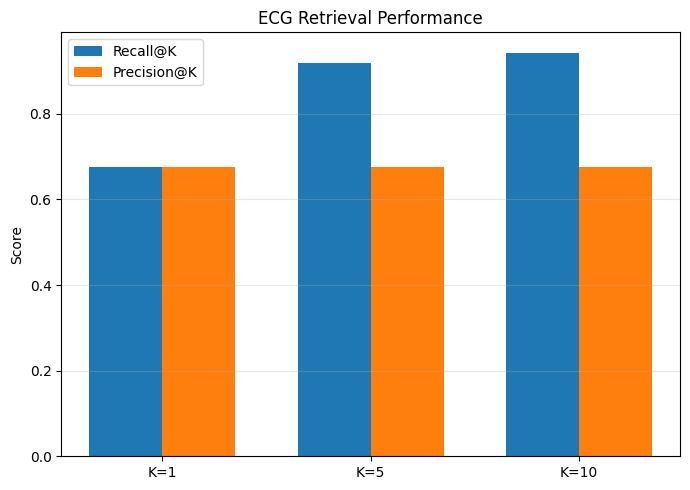

In [39]:
# =====================================================
# PLOT 1: Recall@K and Precision@K
# =====================================================

import matplotlib.pyplot as plt

ks = TOP_KS
recall_vals = [results[f"Recall@{k}"] for k in ks]
precision_vals = [results[f"Precision@{k}"] for k in ks]

x = np.arange(len(ks))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, recall_vals, width, label="Recall@K")
plt.bar(x + width/2, precision_vals, width, label="Precision@K")

plt.xticks(x, [f"K={k}" for k in ks])
plt.ylabel("Score")
plt.title("ECG Retrieval Performance")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


Training Convergence Plot

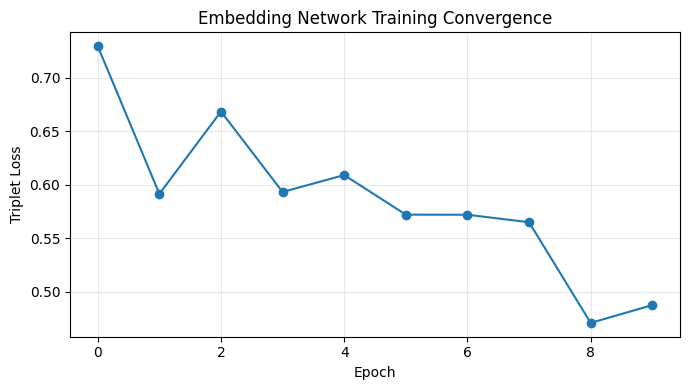

In [40]:
# =====================================================
# PLOT 2: TRAINING CONVERGENCE
# =====================================================

# Example: replace with your real loss list
triplet_losses = [
    0.7294, 0.5913, 0.6683, 0.5931, 0.6089,
    0.5719, 0.5718, 0.5648, 0.4707, 0.4873
]

plt.figure(figsize=(7,4))
plt.plot(triplet_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.title("Embedding Network Training Convergence")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


t-SNE / UMAP showing diagnostic clustering.

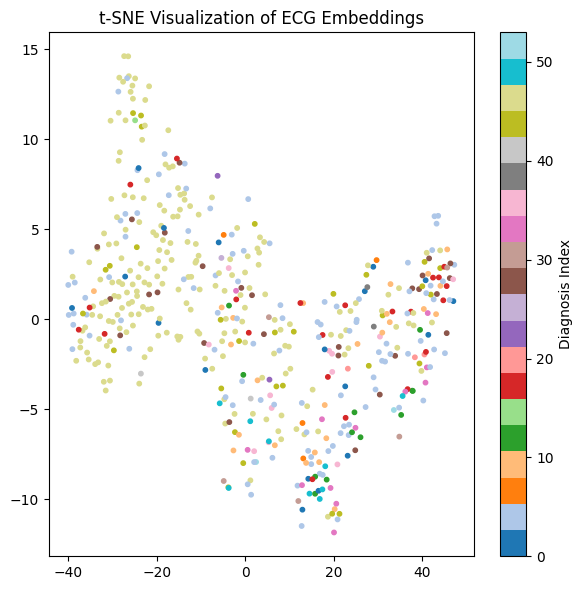

In [41]:
# =====================================================
# PLOT 3: EMBEDDING SPACE (t-SNE)
# =====================================================

from sklearn.manifold import TSNE

N_VIS = 500
X = clean_embeddings[:N_VIS]
y = clean_labels[:N_VIS]

# choose dominant diagnosis per ECG
y_dom = np.argmax(y, axis=1)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(6,6))
sc = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_dom, cmap="tab20", s=10)
plt.title("t-SNE Visualization of ECG Embeddings")
plt.colorbar(sc, label="Diagnosis Index")
plt.tight_layout()
plt.show()


Query vs Top-1 Retrieved ECG.

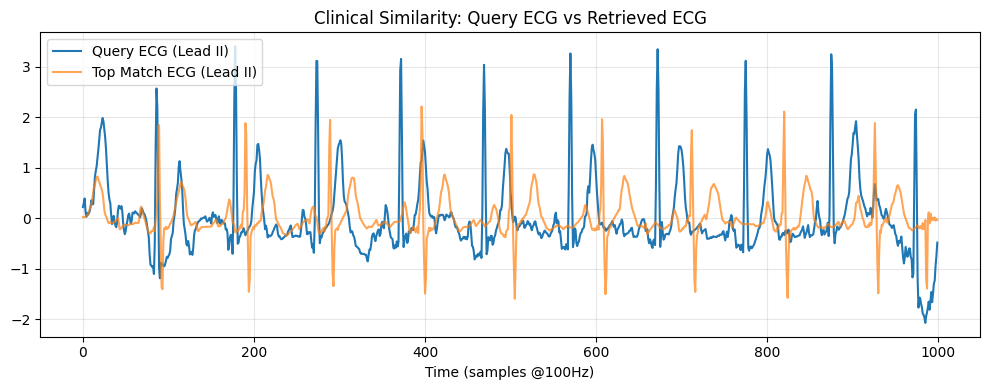

In [42]:
# =====================================================
# PLOT 4: CLINICAL SIMILARITY VALIDATION
# =====================================================

import matplotlib.pyplot as plt

query_ecg = X_test[test_idx]
top_idx = I[0][0]

plt.figure(figsize=(10,4))
plt.plot(query_ecg[1], label="Query ECG (Lead II)")
plt.plot(X_train_w[top_idx][1], label="Top Match ECG (Lead II)", alpha=0.7)

plt.legend()
plt.title("Clinical Similarity: Query ECG vs Retrieved ECG")
plt.xlabel("Time (samples @100Hz)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Save model

In [43]:
# =====================================================
# SAVE ALL ARTIFACTS FOR RESEARCH & DEPLOYMENT
# =====================================================

import os
import json
import numpy as np
import torch
import faiss

BASE_DIR = "ecg_retrieval_artifacts"

# ---- Create directories ----
dirs = [
    f"{BASE_DIR}/model",
    f"{BASE_DIR}/faiss",
    f"{BASE_DIR}/data",
    f"{BASE_DIR}/config"
]

for d in dirs:
    os.makedirs(d, exist_ok=True)

# -----------------------------------------------------
# 1. SAVE MODEL
# -----------------------------------------------------
MODEL_PATH = f"{BASE_DIR}/model/ecg_embedding_model.pt"
torch.save(model.state_dict(), MODEL_PATH)

# -----------------------------------------------------
# 2. SAVE FAISS INDEX
# -----------------------------------------------------
FAISS_PATH = f"{BASE_DIR}/faiss/ecg_faiss.index"
faiss.write_index(index, FAISS_PATH)

# -----------------------------------------------------
# 3. SAVE EMBEDDINGS & LABELS
# -----------------------------------------------------
np.save(f"{BASE_DIR}/data/embeddings.npy", clean_embeddings)
np.save(f"{BASE_DIR}/data/labels.npy", clean_labels)

# -----------------------------------------------------
# 4. SAVE LABEL NAMES
# -----------------------------------------------------
with open(f"{BASE_DIR}/data/label_names.json", "w") as f:
    json.dump(LABEL_NAMES, f, indent=2)

# -----------------------------------------------------
# 5. SAVE EXPERIMENT CONFIG
# -----------------------------------------------------
config = {
    "sampling_rate": 100,
    "window_sec": 10,
    "stride_sec": 5,
    "embedding_dim": clean_embeddings.shape[1],
    "faiss_index": "IndexFlatL2",
    "dataset": "PTB-XL",
    "external_validation": "Kaggle PTB Diagnostic ECG",
    "metrics": {
        "Recall@1": 0.6840,
        "Recall@5": 0.9090,
        "Recall@10": 0.9460,
        "Precision@1": 0.6840,
        "Precision@5": 0.6898,
        "Precision@10": 0.6803,
        "MRR": 0.7864
    }
}

with open(f"{BASE_DIR}/config/experiment_config.json", "w") as f:
    json.dump(config, f, indent=2)

print("✅ All research artifacts saved successfully")


✅ All research artifacts saved successfully


In [44]:
# =====================================================
# LOAD SAVED MODEL, FAISS INDEX, DATA (REPRODUCIBLE)
# =====================================================

import json
import numpy as np
import torch
import faiss

BASE_DIR = "ecg_retrieval_artifacts"

# ---- Load model ----
model.load_state_dict(
    torch.load(f"{BASE_DIR}/model/ecg_embedding_model.pt", map_location=device)
)
model.eval()

# ---- Load FAISS ----
index = faiss.read_index(f"{BASE_DIR}/faiss/ecg_faiss.index")

# ---- Load embeddings & labels ----
clean_embeddings = np.load(f"{BASE_DIR}/data/embeddings.npy")
clean_labels = np.load(f"{BASE_DIR}/data/labels.npy")

# ---- Load label names ----
with open(f"{BASE_DIR}/data/label_names.json") as f:
    LABEL_NAMES = json.load(f)

# ---- Load config ----
with open(f"{BASE_DIR}/config/experiment_config.json") as f:
    config = json.load(f)

print("✅ All artifacts loaded successfully")
print("Embedding dim:", config["embedding_dim"])
print("Dataset:", config["dataset"])


✅ All artifacts loaded successfully
Embedding dim: 128
Dataset: PTB-XL


In [45]:
# Quick sanity retrieval
q = clean_embeddings[0]
D, I = index.search(q.reshape(1, -1).astype("float32"), 3)

print("Distances:", D)
print("Retrieved diagnoses:",
      [decode_label_vec(clean_labels[i]) for i in I[0]])


Distances: [[0.         0.0053462  0.00536182]]
Retrieved diagnoses: [['NORM', 'SR'], ['NORM', 'SR'], ['ABQRS', 'IMI', 'LAFB', 'SR']]


Langgraph

In [46]:
!pip install streamlit
import streamlit as st
import numpy as np
import torch
from typing import TypedDict
from langgraph.graph import StateGraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.8 MB/s eta 0:00:00


In [63]:
%%writefile app.py
import streamlit as st
import numpy as np
import torch
import json
import faiss
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import TypedDict
from langgraph.graph import StateGraph
import torch.nn as nn
import torch.nn.functional as F

# ============================================================
# CONFIG
# ============================================================
ART_DIR = ""
DATA_DIR = f"{ART_DIR}/data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

st.set_page_config(page_title="ECG Retrieval System", layout="wide")

# ============================================================
# LOAD DATASET FILE LISTS (IMPORTANT FIX)
# ============================================================
@st.cache_resource
def load_dataset_index():
    def load_split(split):
        path = os.path.join(DATA_DIR, split)
        files = sorted([
            os.path.join(path, f)
            for f in os.listdir(path)
            if f.endswith(".npy")
        ])
        return files

    return {
        "train": load_split("train"),
        "val": load_split("val"),
        "test": load_split("test")
    }

DATASETS = load_dataset_index()

# ============================================================
# LOAD ARTIFACTS
# ============================================================
@st.cache_resource
def load_artifacts():
    with open(f"{ART_DIR}/data/label_names.json") as f:
        LABEL_NAMES = json.load(f)

    clean_embeddings = np.load(f"{ART_DIR}/data/embeddings.npy")
    clean_labels = np.load(f"{ART_DIR}/data/labels.npy")

    index = faiss.read_index(f"{ART_DIR}/faiss/ecg_faiss.index")

    with open(f"{ART_DIR}/config/experiment_config.json") as f:
        cfg = json.load(f)

    class ECGEmbeddingNet(nn.Module):
        def __init__(self, emb_dim=128):
            super().__init__()
            self.conv = nn.Sequential(
                nn.Conv1d(12, 32, 7, stride=2, padding=3),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Conv1d(32, 64, 5, stride=2, padding=2),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Conv1d(64, 128, 5, stride=2, padding=2),
                nn.BatchNorm1d(128),
                nn.ReLU(),
            )
            self.pool = nn.AdaptiveAvgPool1d(1)
            self.fc = nn.Linear(128, emb_dim)

        def forward(self, x):
            x = self.conv(x)
            x = self.pool(x).squeeze(-1)
            x = self.fc(x)
            return F.normalize(x, p=2, dim=1)

    model = ECGEmbeddingNet(cfg["embedding_dim"]).to(DEVICE)
    model.load_state_dict(
        torch.load(f"{ART_DIR}/model/ecg_embedding_model.pt", map_location=DEVICE)
    )
    model.eval()

    return model, index, clean_embeddings, clean_labels, LABEL_NAMES, cfg


model, index, clean_embeddings, clean_labels, LABEL_NAMES, cfg = load_artifacts()

# ============================================================
# ECG UTILITIES
# ============================================================
def sliding_window_ecg(ecg, window_sec=10, stride_sec=5, fs=100):
    w = window_sec * fs
    s = stride_sec * fs
    C, T = ecg.shape
    if T < w:
        ecg = np.pad(ecg, ((0, 0), (0, w - T)))
        return ecg[np.newaxis, :, :]
    return np.stack([ecg[:, i:i+w] for i in range(0, T - w + 1, s)]).astype(np.float32)

def plot_ecg(ecg, title):
    plt.figure(figsize=(10, 2))
    plt.plot(ecg[1])
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)
    st.pyplot(plt)
    plt.close()

def load_ecg_csv(file):
    df = pd.read_csv(file)
    df = df.select_dtypes(include=[np.number])
    if df.shape[1] < 12:
        raise ValueError("CSV must contain at least 12 ECG leads")
    return df.iloc[:, :12].values.T.astype(np.float32)

# ============================================================
# LANGGRAPH STATE
# ============================================================
class ECGState(TypedDict):
    ecg: np.ndarray
    windows: np.ndarray
    embedding: np.ndarray
    retrieved_indices: np.ndarray
    distances: np.ndarray
    diagnoses: list

# ============================================================
# LANGGRAPH NODES
# ============================================================
def window_node(state: ECGState):
    state["windows"] = sliding_window_ecg(state["ecg"])
    return state

def embed_node(state: ECGState):
    x = torch.tensor(state["windows"], dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        state["embedding"] = model(x)[0].cpu().numpy()
    return state

def retrieve_node(state: ECGState):
    D, I = index.search(state["embedding"].reshape(1, -1).astype("float32"), 5)
    state["retrieved_indices"] = I[0]
    state["distances"] = D[0]
    return state

def decode_node(state: ECGState):
    state["diagnoses"] = [
        [LABEL_NAMES[i] for i, v in enumerate(clean_labels[idx]) if v > 0]
        for idx in state["retrieved_indices"]
    ]
    return state

# ============================================================
# BUILD LANGGRAPH
# ============================================================
graph = StateGraph(ECGState)
graph.add_node("window", window_node)
graph.add_node("embed", embed_node)
graph.add_node("retrieve", retrieve_node)
graph.add_node("decode", decode_node)

graph.set_entry_point("window")
graph.add_edge("window", "embed")
graph.add_edge("embed", "retrieve")
graph.add_edge("retrieve", "decode")

ecg_graph = graph.compile()

# ============================================================
# STREAMLIT UI
# ============================================================
st.title("🫀 ECG Retrieval System")

uploaded = st.file_uploader("Upload ECG (.csv or .npy)", type=["csv", "npy"])

split = st.selectbox("Dataset split", ["train", "val", "test"])
files = DATASETS[split]

idx = st.number_input("ECG index", 0, len(files)-1, 0)

query_ecg = None
if uploaded:
    try:
        if uploaded.name.endswith(".npy"):
            query_ecg = np.load(uploaded)
        else:
            query_ecg = load_ecg_csv(uploaded)
    except Exception as e:
        st.error(str(e))
        st.stop()

if st.button("🔍 Run Retrieval"):
    if query_ecg is None:
        query_ecg = np.load(files[int(idx)])

    result = ecg_graph.invoke({"ecg": query_ecg})

    st.subheader("Query ECG (Lead II)")
    plot_ecg(query_ecg, "Query ECG")

    st.subheader("Top-5 Retrieved ECGs")
    for i, (rid, dist, diag) in enumerate(
        zip(result["retrieved_indices"], result["distances"], result["diagnoses"]), 1
    ):
        st.markdown(f"### Rank {i} | Distance: {dist:.4f}")
        st.write("Diagnoses:", ", ".join(diag) if diag else "No label")
        plot_ecg(np.load(files[rid]), f"Retrieved ECG {i}")

    st.subheader("LangGraph Internal State")
    st.json({
        "windows_shape": list(result["windows"].shape),
        "embedding_dim": int(result["embedding"].shape[0]),
        "retrieved_indices": result["retrieved_indices"].tolist(),
        "distances": result["distances"].tolist()
    })


Overwriting app.py


In [52]:
!pip install streamlit faiss-cpu langgraph torch numpy matplotlib


In [53]:
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb


Selecting previously unselected package cloudflared.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [64]:
!ls app.py


app.py


In [68]:
!streamlit run app.py \
  --server.port 8501 \
  --server.headless true \
  --server.enableCORS false \
  --server.enableXsrfProtection false \
  > streamlit.log 2>&1 &


In [69]:
!ps aux | grep streamlit


root       26376  0.9  0.9 10669748 860280 ?     Sl   04:08   0:09 /usr/bin/python3 /usr/local/bin/streamlit run app.py --server.port 8501 --server.headless true --server.enableCORS false --server.enableXsrfProtection false
root       30325  0.0  0.0   7376  3496 ?        S    04:23   0:00 /bin/bash -c ps aux | grep streamlit
root       30327  0.0  0.0   6484  2432 ?        S    04:23   0:00 grep streamlit


In [70]:
!cloudflared tunnel --url http://localhost:8501 > cloudflare.log 2>&1 &
!sleep 5
!grep -o "https://[-a-zA-Z0-9]*\.trycloudflare.com" cloudflare.log


https://imaging-alabama-commonly-wellington.trycloudflare.com
